In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version
!pip install pyspark 

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_222"
OpenJDK Runtime Environment (build 1.8.0_222-8u222-b10-1ubuntu1~18.04.1-b10)
OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)
     |████████████████████████████████| 215.7MB 60kB/s 
     |████████████████████████████████| 204kB 51.1MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130387 sha256=1238cc225656bd9dbe274eb38f2734ba411dda33a51bd28d3c6932cfd52614d5
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark


## Swiss power grid data.
You can find the data [here](https://www.swissgrid.ch/en/home/operation/grid-data.html). I prepared a subset of the 2019 data for this example in the `CH-2019.csv` file.

In [0]:
from google.colab import files

In [3]:
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
import zipfile

In [0]:
with zipfile.ZipFile('CH-2019.csv.zip', 'r') as in_:
  in_.extractall('.')

In [6]:
!ls -la

total 14676
drwxr-xr-x 1 root root     4096 Dec 10 15:30 .
drwxr-xr-x 1 root root     4096 Dec 10 15:26 ..
-rw-r--r-- 1 root root 10436165 Dec 10 15:30 CH-2019.csv
-rw-r--r-- 1 root root  4572663 Dec 10 15:30 CH-2019.csv.zip
drwxr-xr-x 1 root root     4096 Dec  6 16:53 .config
drwxr-xr-x 1 root root     4096 Dec  6 16:53 sample_data


First we import the data into a Pandas dataframe and take a look.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates as dates
%matplotlib inline

In [0]:
df = pd.read_csv('CH-2019.csv')

In [9]:
df.columns

Index(['Zeitstempel',
       'Total energy consumed by end users in the Swiss controlblock',
       'Total energy production Swiss controlblock',
       'Total energy consumption Swiss controlblock',
       'Net outflow of the Swiss transmission grid',
       'Grid feed-in Swiss transmission grid',
       'Positive secundary control energy',
       'Negative secundary control energy', 'Positive tertiary control energy',
       'Negative tertiary control energy', 'Cross Border Exchange CH->AT',
       'Cross Border Exchange AT->CH', 'Cross Border Exchange CH->DE',
       'Cross Border Exchange DE->CH', 'Cross Border Exchange CH->FR',
       'Cross Border Exchange FR->CH', 'Cross Border Exchange CH->IT',
       'Cross Border Exchange IT->CH', 'Transit', 'Import', 'Export',
       'Average positive secondary control energy prices',
       'Average negative secondary control energy prices',
       'Average positive tertiary control energy prices',
       'Average negative tertiary control 

We want to create an index on the `'Zeitstempel'` (timestamp) attribute.

In [0]:
df.index = pd.DatetimeIndex(df['Zeitstempel'])

Then we correct any numerical error, forcing them to be presented as `NaN`

In [0]:
df = df.apply(pd.to_numeric, errors='coerce', axis=1)

In [0]:
df.info()

In [13]:
df.describe()

,Zeitstempel,Total energy consumed by end users in the Swiss controlblock,Total energy production Swiss controlblock,Total energy consumption Swiss controlblock,Net outflow of the Swiss transmission grid,Grid feed-in Swiss transmission grid,Positive secundary control energy,Negative secundary control energy,Positive tertiary control energy,Negative tertiary control energy,Cross Border Exchange CH->AT,Cross Border Exchange AT->CH,Cross Border Exchange CH->DE,Cross Border Exchange DE->CH,Cross Border Exchange CH->FR,Cross Border Exchange FR->CH,Cross Border Exchange CH->IT,Cross Border Exchange IT->CH,Transit,Import,Export,Average positive secondary control energy prices,Average negative secondary control energy prices,Average positive tertiary control energy prices,Average negative tertiary control energy prices,Production Canton AG,Consumption Canton AG,Production Canton FR,Consumption Canton FR,Production Canton GL,Consumption Canton GL,Production Canton GR,Consumption Canton GR,Production Canton LU,Consumption Canton LU,Production Canton NE,Consumption Canton NE,Production Canton SO,Consumption Canton SO,Production Canton SG,Consumption Canton SG,Production Canton TI,Consumption Canton TI,Production Canton TG,Consumption Canton TG,Production Canton VS,Consumption Canton VS,"Production Cantons AI, AR","Consumption Cantons AI, AR","Production Cantons BL, BS","Consumption Cantons BL, BS","Production Cantons BE, JU","Consumption Cantons BE, JU","Production Cantons SZ, ZG","Consumption Cantons SZ, ZG","Production Cantons OW, NW, UR","Consumption Cantons OW, NW, UR","Production Cantons GE, VD","Consumption Cantons GE, VD","Production Cantons SH, ZH","Consumption Cantons SH, ZH",Production across Cantons,Consumption across Cantons,Production control area CH - foreign territories,Consumption control area CH - foreign territories
count,0.0,1.737100e+04,1.737100e+04,1.737100e+04,17371.000000,1.737100e+04,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,1.737100e+04,17371.000000,17371.000000,1.737100e+04,17371.000000,1.737100e+04,1.737100e+04,1.737100e+04,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.00000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000
mean,NaN,1.654709e+06,1.830452e+06,1.869179e+06,199575.056966,1.295846e+06,5473.155316,-4494.572679,4724.961142,-3786.713488,37320.649358,200839.514133,131605.706350,4.391306e+05,118158.528237,250809.865796,5.947491e+05,30538.412814,6.979404e+05,9.200536e+05,8.813326e+05,52.539999,33.753696,16.915211,0.494444,408633.038021,143387.014550,32109.268414,76302.504916,35291.721605,20816.314523,202757.111717,77521.057523,16761.211055,102814.375805,895.330012,18401.960883,235978.448691,60894.900982,28993.837862,107703.137535,90963.260722,86537.653007,6124.707097,51252.468491,249256.362453,100310.164205,2887.424749,15764.162947,25596.337027,99201.342267,211553.580787,231308.867300,11907.917138,51063.160630,29829.99184,26198.173283,81126.349219,228594.584477,26815.026703,270812.666050,87055.681046,49941.838486,882.000368,8142.362858
std,NaN,2.930864e+05,5.023525e+05,2.362564e+05,227725.986086,4.170296e+05,9809.954857,8565.152025,11951.928305,8998.565095,38133.121235,112433.238585,156196.199843,2.940662e+05,128956.105922,119824.327629,2.053473e+05,43959.613388,2.351291e+05,3.928907e+05,2.476199e+05,14.762528,11.207372,85.441413,23.150266,114842.210781,23493.961237,17115.240768,14335.389527,23982.623160,15031.266174,152677.470811,18216.585393,9313.862822,16509.421233,641.506421,4154.778603,81628

In [14]:
df.head()

,Zeitstempel,Total energy consumed by end users in the Swiss controlblock,Total energy production Swiss controlblock,Total energy consumption Swiss controlblock,Net outflow of the Swiss transmission grid,Grid feed-in Swiss transmission grid,Positive secundary control energy,Negative secundary control energy,Positive tertiary control energy,Negative tertiary control energy,Cross Border Exchange CH->AT,Cross Border Exchange AT->CH,Cross Border Exchange CH->DE,Cross Border Exchange DE->CH,Cross Border Exchange CH->FR,Cross Border Exchange FR->CH,Cross Border Exchange CH->IT,Cross Border Exchange IT->CH,Transit,Import,Export,Average positive secondary control energy prices,Average negative secondary control energy prices,Average positive tertiary control energy prices,Average negative tertiary control energy prices,Production Canton AG,Consumption Canton AG,Production Canton FR,Consumption Canton FR,Production Canton GL,Consumption Canton GL,Production Canton GR,Consumption Canton GR,Production Canton LU,Consumption Canton LU,Production Canton NE,Consumption Canton NE,Production Canton SO,Consumption Canton SO,Production Canton SG,Consumption Canton SG,Production Canton TI,Consumption Canton TI,Production Canton TG,Consumption Canton TG,Production Canton VS,Consumption Canton VS,"Production Cantons AI, AR","Consumption Cantons AI, AR","Production Cantons BL, BS","Consumption Cantons BL, BS","Production Cantons BE, JU","Consumption Cantons BE, JU","Production Cantons SZ, ZG","Consumption Cantons SZ, ZG","Production Cantons OW, NW, UR","Consumption Cantons OW, NW, UR","Production Cantons GE, VD","Consumption Cantons GE, VD","Production Cantons SH, ZH","Consumption Cantons SH, ZH",Production across Cantons,Consumption across Cantons,Production control area CH - foreign territories,Consumption control area CH - foreign territories
Zeitstempel,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:15:00,NaN,1540677.903,1.348752e+06,1.806899e+06,410240.653877,993708.397313,4164.0,-5300.0,0.0,0.0,600.0,246700.0,41059.0,871268.0,225431.5,100550.00,539342.0,62378.0,804486.50,1279259.75,804486.50,60.31,40.21,0.0,0.0,472231.569,126134.893,10249.690,69918.522,43588.952,14913.165,56604.303,75362.770,8242.750,91239.974,781.46,14835.09,268887.388,51336.320,10791.7948,95981.6026,25708.699,79706.800,3339.399,46304.754,106368.854313,104900.351460,1853.9352,15531.5734,26170.083,88054.869,141293.685,226741.503,2748.317,51631.049,12255.289,29345.122,39807.981,254133.631,22384.238,258097.952,80786.005,58314.235123,279.675,4216.443
2019-01-01 00:30:00,NaN,1527957.369,1.334608e+06,1.776318e+06,401305.931042,988114.538189,350.0,-773.0,0.0,0.0,10400.0,194100.0,33072.0,774948.0,215231.5,100550.00,434424.0,76075.0,694165.50,1144678.75,694165.50,60.31,40.21,0.0,0.0,472294.176,124564.392,10201.835,68029.867,39323.973,14584.246,53091.283,75337.136,7457.739,90450.590,803.81,14415.19,269445.598,50124.857,10639.4328,81980.1698,24518.384,78847.839,3288.846,46140.535,109826.590189,103836.825001,1857.2432,15206.3622,25616.990,87377.787,140411.546,227358.992,2720.468,50346.375,10934.633,28984.733,37456.380,253940.685,21566.876,256777.717,78857.380,53410.971958,275.225,4224.925
2019-01-01 00:45:00,NaN,1517270.229,1.311103e+06,1.765328e+06,413895.084322,974374.887781,26.0,-18803.0,0.0,0.0,34200.0,181500.0,24616.0,769684.0,220831.5,100550.00,407112.0,80902.0,683261.50,1132264.75,683261.50,60.31,40.21,0.0,0.0,472517.156,128084.410,10225.015,66444.822,34005.602,14453.155,49651.555,75445.970,7278.729,88346.848,788.25,13993.58,269515.977,51070.882,10619.0496,79923.6996,22629.614,77834.407,3282.145,45638.048,97288.372781,103031.681017,1847.7614,14861.0804,25593.616,86636.643,142917.092,229917.721,2730.163,49529.171,11570.089,28902.417,34904.344,251520.850,21273.801,252599.963,78268.807,52942.335678,274.975,4034.285
2019-01-01 01:00:00,NaN,1496935.964,1.285616e+06,1.753107e+06,424850.327064,962578.413498,0.0,-31141.0,0.0,0.0,33600.0,182800.0,21290.0,757



Features are represented by individual columns and every row is a set of measurements. Let's create a long list of energy production measurements at individual cantons, where a measurement consists of

    * a time stamp
    * a categorical identifier
    * a numerical measurement



In [15]:
df_prod = pd.DataFrame(columns=['Cantons', 'Production'])
for c in df.columns:
    if 'Production Canton' in c:
        cantons = ''.join(c.split()[2:])
        df_temp = pd.DataFrame(index = df.index, columns=['Cantons', 'Production'])
        df_temp.Production = df[c]
        df_temp.Cantons = cantons
        df_prod = df_prod.append(df_temp)
print ('Number of production measurements:', len(df_prod.index))
df_prod.head()

Number of production measurements: 312678


,Cantons,Production
2019-01-01 00:15:00,AG,472231.569
2019-01-01 00:30:00,AG,472294.176
2019-01-01 00:45:00,AG,472517.156
2019-01-01 01:00:00,AG,472364.694
2019-01-01 01:15:00,AG,472327.640


And let's save it for further use.

In [0]:
df_prod.to_csv('production.csv')

One of the great functionalities of `pandas` dataframes is how it handles time series data. The energy production dataframe we just created uses a `DatetimeIndex`. This makes it trivial to resample our measurements from 15 min to another time window:

In [17]:
df_prod_wide = df_prod.pivot(columns='Cantons').resample('1 d').sum()
df_prod_wide.head()


Production               ...                            
Cantons               AG        AI,AR  ...            TI            VS
2019-01-01  4.481835e+07  195280.4430  ...  2.696213e+06  9.340840e+06
2019-01-02  4.531299e+07  174472.0518  ...  4.832765e+06  1.276012e+07
2019-01-03  4.541924e+07  161824.3504  ...  9.570662e+06  1.928944e+07
2019-01-04  4.540318e+07  153592.6378  ...  1.128582e+07  2.375556e+07
2019-01-05  4.522894e+07  108475.5722  ...  7.585191e+06  1.618735e+07

[5 rows x 18 columns]

In [18]:
!wc -l production.csv

312679 production.csv


Text(0.5, 0, 'Time')

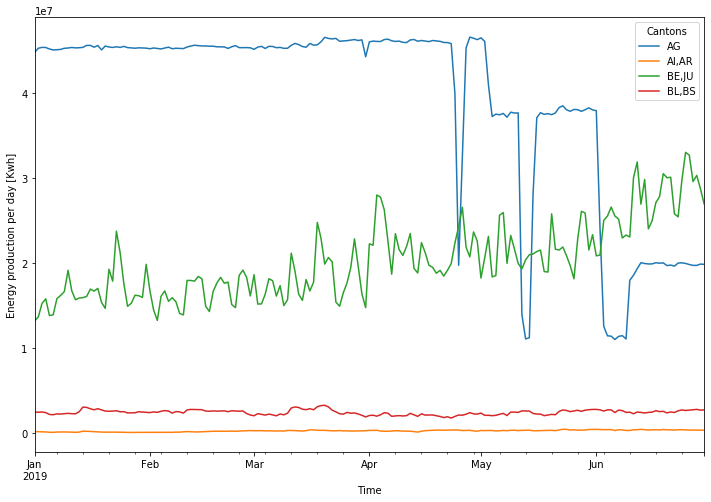

In [19]:
fig, axarr = plt.subplots(1, 1, figsize=(12,8))
df_prod_wide.Production[['AG', 'AI,AR', 'BE,JU', 'BL,BS']].plot(ax=axarr)
axarr.set_ylabel('Energy production per day [Kwh]')
axarr.set_xlabel('Time')


Let's switch to `spark` to achieve the same transformation.

In [0]:
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import *

In [0]:
spark = SparkSession.builder.appName('ts').getOrCreate()

In [0]:
sc = spark.sparkContext

In [0]:
sqlContext = SQLContext(sc)

In [0]:
sdf = sqlContext.read.csv('production.csv', header=True, inferSchema=True)

In [25]:
print('Number of rows', sdf.count())

Number of rows 312678


In [26]:
sdf.printSchema()

root
 |-- _c0: timestamp (nullable = true)
 |-- Cantons: string (nullable = true)
 |-- Production: double (nullable = true)



In [27]:
sdf.show()

+-------------------+-------+------------------+
|                _c0|Cantons|        Production|
+-------------------+-------+------------------+
|2019-01-01 00:15:00|     AG|472231.56899999996|
|2019-01-01 00:30:00|     AG|472294.17600000004|
|2019-01-01 00:45:00|     AG|        472517.156|
|2019-01-01 01:00:00|     AG|472364.69399999996|
|2019-01-01 01:15:00|     AG|         472327.64|
|2019-01-01 01:30:00|     AG|        472554.439|
|2019-01-01 01:45:00|     AG|        472494.494|
|2019-01-01 02:00:00|     AG|        471583.388|
|2019-01-01 02:15:00|     AG|472345.93700000003|
|2019-01-01 02:30:00|     AG|        472217.701|
|2019-01-01 02:45:00|     AG|        472303.441|
|2019-01-01 03:00:00|     AG|         472283.96|
|2019-01-01 03:15:00|     AG|472301.80299999996|
|2019-01-01 03:30:00|     AG|472021.24600000004|
|2019-01-01 03:45:00|     AG|        472117.265|
|2019-01-01 04:00:00|     AG|472262.13899999997|
|2019-01-01 04:15:00|     AG|        472035.251|
|2019-01-01 04:30:00

We can format the timestamp according to our need.

In [28]:
sdf.select('_c0', date_format('_c0', 'HH:mm').alias('time'), date_format('_c0', 'E').alias('weekday'), date_format('_c0', 'u HH:mm').alias('weekdaytime')).show()

+-------------------+-----+-------+-----------+
|                _c0| time|weekday|weekdaytime|
+-------------------+-----+-------+-----------+
|2019-01-01 00:15:00|00:15|    Tue|    2 00:15|
|2019-01-01 00:30:00|00:30|    Tue|    2 00:30|
|2019-01-01 00:45:00|00:45|    Tue|    2 00:45|
|2019-01-01 01:00:00|01:00|    Tue|    2 01:00|
|2019-01-01 01:15:00|01:15|    Tue|    2 01:15|
|2019-01-01 01:30:00|01:30|    Tue|    2 01:30|
|2019-01-01 01:45:00|01:45|    Tue|    2 01:45|
|2019-01-01 02:00:00|02:00|    Tue|    2 02:00|
|2019-01-01 02:15:00|02:15|    Tue|    2 02:15|
|2019-01-01 02:30:00|02:30|    Tue|    2 02:30|
|2019-01-01 02:45:00|02:45|    Tue|    2 02:45|
|2019-01-01 03:00:00|03:00|    Tue|    2 03:00|
|2019-01-01 03:15:00|03:15|    Tue|    2 03:15|
|2019-01-01 03:30:00|03:30|    Tue|    2 03:30|
|2019-01-01 03:45:00|03:45|    Tue|    2 03:45|
|2019-01-01 04:00:00|04:00|    Tue|    2 04:00|
|2019-01-01 04:15:00|04:15|    Tue|    2 04:15|
|2019-01-01 04:30:00|04:30|    Tue|    2

Read [this](https://spark.apache.org/docs/latest/sql-programming-guide.html) and [this](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=window)

In [0]:
group = sdf.groupBy('Cantons', window('_c0', '1 day')).agg(sum('Production').alias('Sum Production'))

In [30]:
group.show()

+--------+--------------------+--------------------+
| Cantons|              window|      Sum Production|
+--------+--------------------+--------------------+
|      GL|[2019-02-27 00:00...|   2414349.978999999|
|      LU|[2019-05-29 00:00...|  2734253.4999999995|
|      SO|[2019-02-05 00:00...|2.1772496117999997E7|
|      SO|[2019-02-07 00:00...| 2.526672807300001E7|
|      SO|[2019-04-29 00:00...|2.6173750744000006E7|
|      SG|[2019-04-19 00:00...|        3136066.3826|
|      SG|[2019-06-19 00:00...|         5795977.524|
|      TI|[2019-05-29 00:00...|         9471010.759|
|      TG|[2019-02-20 00:00...|   566683.9829999998|
|      VS|[2019-06-17 00:00...|3.7673833090193994E7|
|   AI,AR|[2019-02-06 00:00...|  108783.89079999998|
|   AI,AR|[2019-05-12 00:00...|  339841.41240000003|
|   BL,BS|[2019-05-02 00:00...|         2105842.627|
|   BL,BS|[2019-05-17 00:00...|   2247371.350999999|
|   BE,JU|[2019-02-27 00:00...|1.8352017538000003E7|
|OW,NW,UR|[2019-02-14 00:00...|   1829400.8790

In [0]:
sdf_resampled = group.select(group.window.start.alias('Start'), group.window.end.alias('End'), 'Cantons', 'Sum Production').orderBy('Start', ascending=True)

In [32]:
sdf_resampled.show()

+-------------------+-------------------+--------+--------------------+
|              Start|                End| Cantons|      Sum Production|
+-------------------+-------------------+--------+--------------------+
|2019-01-01 00:00:00|2019-01-02 00:00:00|      AG|4.4818346434000015E7|
|2019-01-01 00:00:00|2019-01-02 00:00:00|   AI,AR|  195280.44300000003|
|2019-01-01 00:00:00|2019-01-02 00:00:00|      TI|  2696212.8759999997|
|2019-01-01 00:00:00|2019-01-02 00:00:00|   SH,ZH|  2162353.6970000006|
|2019-01-01 00:00:00|2019-01-02 00:00:00|      LU|            914049.6|
|2019-01-01 00:00:00|2019-01-02 00:00:00|      SO|2.5591929794000007E7|
|2019-01-01 00:00:00|2019-01-02 00:00:00|   GE,VD|   2776129.849000001|
|2019-01-01 00:00:00|2019-01-02 00:00:00|      VS|      9340839.576657|
|2019-01-01 00:00:00|2019-01-02 00:00:00|OW,NW,UR|         1027715.299|
|2019-01-01 00:00:00|2019-01-02 00:00:00|      FR|  1050582.3229999996|
|2019-01-01 00:00:00|2019-01-02 00:00:00|      GR|         47759

In [0]:
sdf_wide = sdf_resampled.groupBy('Start').pivot('Cantons').agg(avg('Sum Production'))

In [34]:
sdf_wide.take(2)

[Row(Start=datetime.datetime(2019, 1, 1, 0, 0), AG=44818346.434000015, AI,AR=195280.44300000003, BE,JU=13225771.515, BL,BS=2503429.073, FR=1050582.3229999996, GE,VD=2776129.849000001, GL=2283761.159, GR=4775976.264, LU=914049.6, NE=49001.189, OW,NW,UR=1027715.299, SG=1281120.2170000006, SH,ZH=2162353.6970000006, SO=25591929.794000007, SZ,ZG=476786.68400000007, TG=330690.81100000005, TI=2696212.8759999997, VS=9340839.576657),
 Row(Start=datetime.datetime(2019, 1, 2, 0, 0), AG=45312992.10099999, AI,AR=174472.05180000004, BE,JU=13687139.187000003, BL,BS=2465978.4099999997, FR=1476352.4610000004, GE,VD=4297179.277999997, GL=2637113.314999999, GR=13463872.721000003, LU=844397.1729999998, NE=45342.041, OW,NW,UR=1355804.7680000002, SG=1197818.3832000005, SH,ZH=2275035.335, SO=25736395.479, SZ,ZG=533554.3600000001, TG=341386.95200000005, TI=4832765.276999999, VS=12760120.855771003)]

In [35]:
sdf_wide.show()

+-------------------+--------------------+------------------+--------------------+------------------+------------------+--------------------+------------------+--------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+--------------------+--------------------+
|              Start|                  AG|             AI,AR|               BE,JU|             BL,BS|                FR|               GE,VD|                GL|                  GR|               LU|                NE|          OW,NW,UR|                SG|             SH,ZH|                  SO|             SZ,ZG|                TG|                  TI|                  VS|
+-------------------+--------------------+------------------+--------------------+------------------+------------------+--------------------+------------------+--------------------+-----------------+------------------+------------------+---------

Let's return to `pandas` to do the plotting.

In [0]:
pdf_wide = sdf_wide.toPandas().set_index('Start').divide(1e6)

Text(0, 0.5, 'Gwh/day')

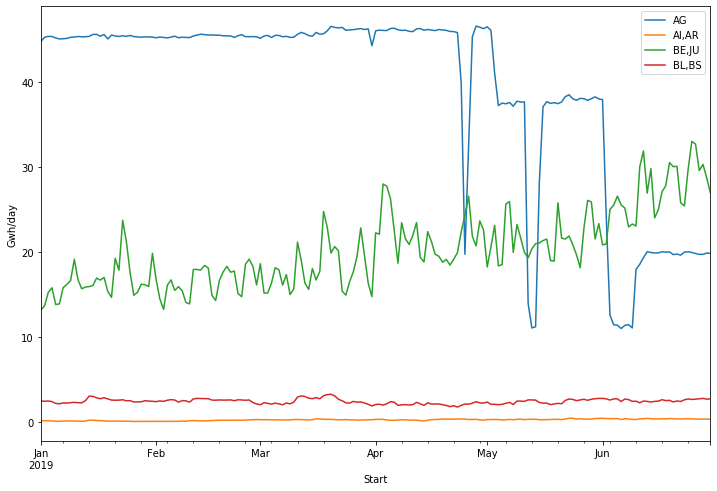

In [37]:
fig, axarr = plt.subplots(1, 1, figsize=(12,8))
pdf_wide[['AG', 'AI,AR', 'BE,JU', 'BL,BS']].plot(ax=axarr)
axarr.set_ylabel('Gwh/day')